# IoT Analysis for a Hydroponic Vertical Farm: Exploration & Prep for Modeling

In the previous post, we implemented a pipeline to read in and tidy raw data received from an IoT network for an automated vertical farm prototype. Next, we will implement this pipeline to process data collected for a developmental experiment, which we will then explore through visualizations.

In [1]:
# package imports
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, ConciseDateFormatter

# data prepared with code detailed in previous notebook
data = pd.read_csv('RF_data1.csv').set_index('Time')
data.index = data.index.astype(np.datetime64)

## Experimenting with the System

The farm's design depends on the system's ability to automatically administer dosage of store-bought **nutrient nix** solution as well as **pH up** and **pH down** solutions to the system's water. Since **conductivity** is directly affected by the nutrient mix, it can be used as a proxy measurement for the water's nutrient levels, helping to inform the system's decision about when to dose with nutrient mix.  

However, conductivity is also affected by the pH Up solution (and, to a lesser extent, pH Down). To help the system make these dosage decisions, we designed and conducted a series of experiments to generate data to model each solution's impact on the water's conductivity and come up with an "adjusted conductivity" calculation to use for dosage decisions in place of the raw conductivity reading.  The data used in this notebook was generated from the first of these experiments, where a fraction of a dose of pH up solution was added periodically over the course of a day.

## Visualization of Results

For the time being, we just want to gain some understanding of how conductivity and pH are affected by pH Up dosing. Below, we plot both measurements throughout the experiment. Because they are quite noisy, we smooth out the curves using rolling means with a window of 12 (with the rows at 5s intervals, this is equal to one minute). We also add vertical lines marking pH up dosing events.

**NOTE:** The dosing amount for each addition was set to 5mL until the final 3 additions, where 25mL doses were added.

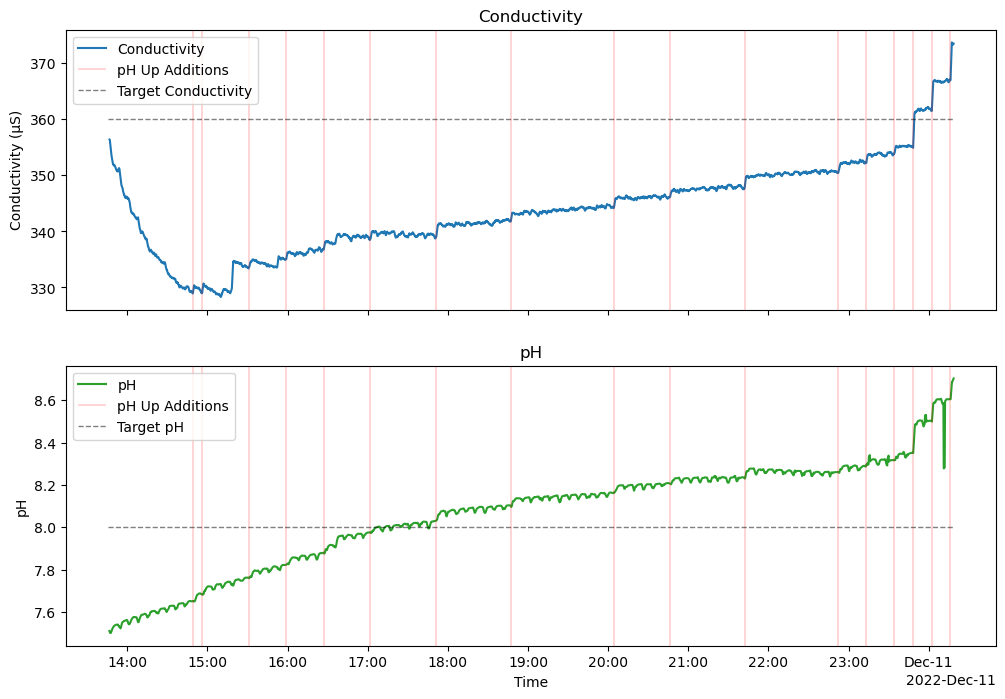

In [2]:
# identify dosing events
doses = np.array(data[~data.pH_Up_Dosing.isna() & data.pH_Up_Dosing!=0].index)

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,8), dpi=100)

### Plot Conductivity with pH_Up_Dosing and target ###
ec_plot = axs[0]

ec_plot.plot(data.Conductivity.rolling(12).mean(), color='C0', label='Conductivity')
ec_plot.set_ylim(ec_plot.get_ylim())
ec_plot.vlines(x=doses, ymin=200, ymax=500, colors='red', lw=.3, alpha=.8,
            label='pH Up Additions')

# Set and plot target Conductivity
target_ec = 360
ec_plot.hlines(y=target_ec, xmin=data.index.min(), xmax=data.index.max(), 
               color='black', linestyle='--', alpha=.5, label='Target Conductivity', lw=1)

# Set plot title and y-axis label
ec_plot.set_title('Conductivity')
ec_plot.set_ylabel('Conductivity (\u03bcS)')

# Add legend and specify its location
ec_plot.legend(loc='upper left')

### Plot pH with pH_Up_Dosing and target ###

# Mostly the same as above, with difference being x-axis adjustments
ph_plot = axs[1]
ph_plot.plot(data.pH.rolling(12).mean(), color='C2', label='pH')
ph_plot.set_ylim(ph_plot.get_ylim())

ph_plot.vlines(x=doses, ymin=7, ymax=9.1, colors='red', lw=.3, alpha=.8,
            label='pH Up Additions')

target_ph = 8
ph_plot.hlines(y=8, xmin=data.index.min(), xmax=data.index.max(), color='black',
               linestyle='--', alpha=.5, label='Target pH', lw=1)

ph_plot.set_title('pH')
ph_plot.set_ylabel('pH')

# Since the two plots share an x-axis, I only have to configure it for the bottom one.
ph_plot.set_xlabel('Time')
ph_plot.xaxis.set_major_formatter(ConciseDateFormatter(HourLocator()))

ph_plot.legend(loc='upper left')
plt.show()

## Discussion

Considering these plots, we can see that **adding pH Up appears to have an obvious and immediate impact on both conductivity and pH**, as each addition of pH Up (indicated by the faint vertical red lines) is immediately followed by an uptick in the measurement. This is the expected outcome, which leaves us with the problem of determining just *how much* we can expect these values to change, and to do the same for the Nutrient Mix and the pH Down solutions. 

### Time-Series Considerations

Concerningly, we can see signs of **trending** in both measurements, with the conductivity dropping quickly at the beginning of the dataset then rising steadily, and the pH rising steadily as well. Both of these phenomena can be partially explained by the fact that the water used for this experiment was drawn fresh from the tap and had not been allowed adequate time to equilibrate with the environment. Indeed, a look at the plot below shows that the system's water temperature dropped slowly throughout the experiment and had still not stabilized when the experiment ended.

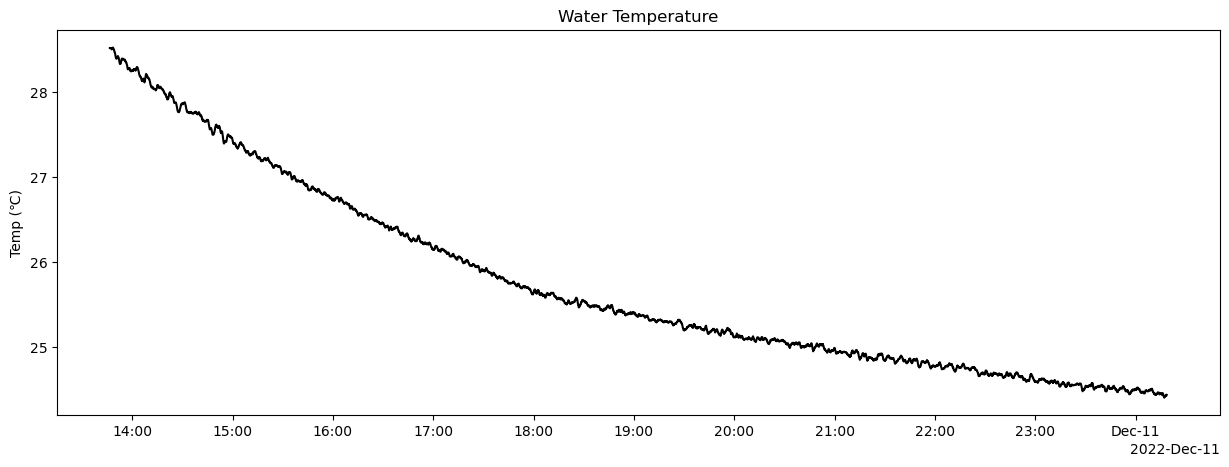

In [28]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(data['Water Temp'].rolling(12).mean(), color='black')
ax.set_title('Water Temperature')
ax.set_ylabel('Temp (\u2103)')
ax.xaxis.set_major_formatter(ConciseDateFormatter(HourLocator()))

It would make sense for the changing temperature to affect both conductivity and pH levels in the water, since temperature affects water's solubility, which impacts the ionic strength of a solution, which in turn impacts both conductivity and pH. These effects can be accounted for in future experiments by allowing the system to equilibrate prior to data collection - however, we should still be wary of any trending in these values, and will use the technique of first-differencing to detrend prior to modeling.